## Reference Model

In [1]:
import maxentep
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import scipy.stats as ss
plt.style.use('seaborn-darkgrid')
# disabling gpu for now
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [2]:
M = 4
R = np.abs(np.random.normal(size=(M,M), loc=1.25))
R = R / np.sum(R, axis=1).reshape(M,1)
R, np.sum(R, axis=1)

(array([[0.18290003, 0.17947439, 0.27576672, 0.36185885],
        [0.20601464, 0.2533361 , 0.31997285, 0.22067641],
        [0.23901612, 0.51588335, 0.04859284, 0.19650769],
        [0.83287634, 0.02781444, 0.08356508, 0.05574414]]),
 array([1., 1., 1., 1.]))

In [3]:
# compartment parameters
compartments = ['E', 'A', 'I', 'R']
infections_compartments = [1,2]
C = len(compartments)
tmat = maxentep.TransitionMatrix(compartments, infections_compartments)
tmat.add_transition('E', 'A', 7, 2)
tmat.add_transition('A', 'I', 3, 2)
tmat.add_transition('I', 'R', 14, 4)

In [4]:
start = np.zeros((M, C))
start[0, 0] = 0.1

In [5]:
infect = maxentep.contact_infection_func(infections_compartments)
model = maxentep.MetaModel(infect, 250)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



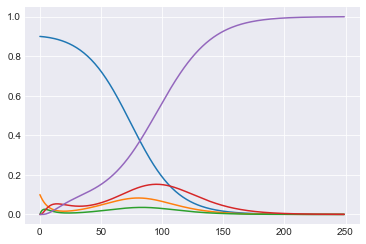

In [6]:
ref_traj = model(R, tmat.value, start, 0.1)[0]
plt.plot(ref_traj[:,0])

## Sample SEIR Trajectories 

Use different compartment dist

In [7]:
# compartment parameters
compartments = ['E', 'I', 'R']
infections_compartments = [1]
C = len(compartments)
tmat = maxentep.TransitionMatrix(compartments, infections_compartments)
tmat.add_transition('E', 'I', 7, 2)
tmat.add_transition('I', 'R', 4, 4)

In [8]:
param_model = maxentep.MetaParameterJoint(np.zeros((M,)), R * 0.8, tmat, name='unbiased_model')

In [9]:
import tqdm
#tf.debugging.enable_check_numerics()
N = 512
batches = 16
outs = []
infect = maxentep.contact_infection_func(infections_compartments)
model = maxentep.MetaModel(infect, 250)
for b in tqdm.tqdm(range(batches)):
    ps = param_model.sample(N)
    outs.append(model(*ps))
trajs = np.concatenate(outs, axis=0)
print(trajs.shape)

100%|█████████████████████████████████████████████████████████████████████████| 16/16 [00:11<00:00,  1.39it/s]

(8192, 250, 4, 4)


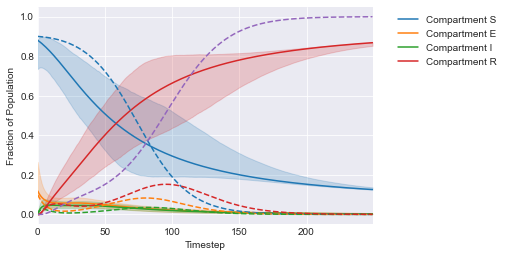

In [10]:
full_compartments = ['S'] + compartments
maxentep.traj_quantile(trajs[:,:,0,:], names=full_compartments, plot_means=True)
plt.plot(ref_traj[:,0], linestyle='--')
plt.show()


## Make restraints from reference trajectory


Using only first half of trajectory and use the R compartment in patch 0

In [11]:
npoints = 5
prior = maxentep.Laplace(0.1)
#prior = maxentep.EmptyPrior() # can try empty to compare with regressed
restraints, plot_fxns = maxentep.traj_to_restraints(ref_traj[:125,:,:], [0, -1], npoints, prior, noise=0.05)

108 0.6479889 0.7011878188581234
101 0.5748964 0.5639148966979196
45 0.13270196 0.05490075153075498
3 0.0012169888 0.0
24 0.06677431 0.08451809908940801


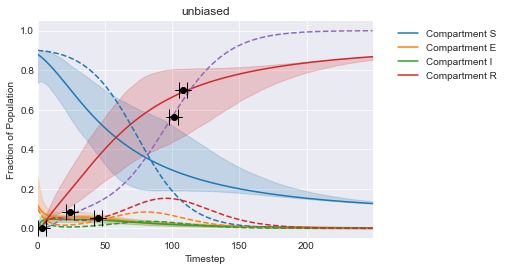

In [12]:
maxentep.traj_quantile(trajs[:,:,0,:], names=full_compartments, plot_means=True)
plt.title('unbiased')
plt.plot(ref_traj[:,0], linestyle='--')
for i,pf in enumerate(plot_fxns):
    pf(plt.gca(), 0)
plt.show()

In [13]:
me_model = maxentep.MaxentModel(restraints)
me_model.compile(tf.keras.optimizers.Adam(learning_rate=1e-2), 'mean_squared_error')

In [14]:
class CustomCallback(tf.keras.callbacks.Callback):
    def __init__(self):
        self. i = 0
    def on_epoch_begin(self, epoch, logs=None):
        self.i += 1
        return self.i

In [19]:
history = me_model.fit(trajs, batch_size=8,epochs=10, callbacks=[CustomCallback()])

Epoch 1/10
1024/1024 [==============================] - 1s 586us/step - loss: 0.0102 - weight-entropy: 1.6840
Epoch 2/10
1024/1024 [==============================] - 1s 617us/step - loss: 0.0098 - weight-entropy: 1.6697
Epoch 3/10
1024/1024 [==============================] - 1s 612us/step - loss: 0.0090 - weight-entropy: 1.6786
Epoch 4/10
1024/1024 [==============================] - 1s 604us/step - loss: 0.0085 - weight-entropy: 1.6675
Epoch 5/10
1024/1024 [==============================] - 1s 621us/step - loss: 0.0087 - weight-entropy: 1.6794
Epoch 6/10
1024/1024 [==============================] - 1s 622us/step - loss: 0.0089 - weight-entropy: 1.6860
Epoch 7/10
1024/1024 [==============================] - 1s 581us/step - loss: 0.0086 - weight-entropy: 1.6762
Epoch 8/10
1024/1024 [==============================] - 1s 599us/step - loss: 0.0088 - weight-entropy: 1.6802
Epoch 9/10
1024/1024 [==============================] - 1s 630us/step - loss: 0.0083 - weight-entropy: 1.6788
Epoch 10/1

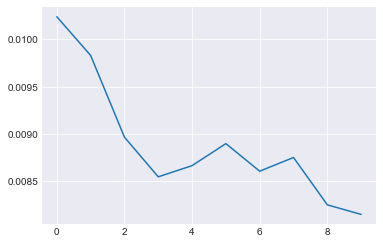

In [20]:
plt.plot(history.history['loss'])

## Using Algorithm 2

In [21]:
fit_param_model = maxentep.MetaParameterJoint(np.zeros((M,)), R, tmat, name='unbiased_model')
fit_param_model.compile(tf.optimizers.Adam(0.1))
hme_model = maxentep.HyperMaxentModel(restraints, fit_param_model, model)
hme_model.compile(tf.keras.optimizers.Adam(learning_rate=1e-2), 'mean_squared_error')

In [22]:
history = hme_model.fit(N, final_batch_multiplier=batches, outter_epochs=25, batch_size=32, epochs=8)

Epoch 1/8
16/16 [==============================] - 0s 813us/step - loss: 0.0244 - weight-entropy: 3.4357
Epoch 2/8
16/16 [==============================] - 0s 750us/step - loss: 0.0206 - weight-entropy: 3.4024
Epoch 3/8
16/16 [==============================] - 0s 813us/step - loss: 0.0184 - weight-entropy: 3.3732
Epoch 4/8
16/16 [==============================] - 0s 751us/step - loss: 0.0197 - weight-entropy: 3.3641
Epoch 5/8
16/16 [==============================] - 0s 750us/step - loss: 0.0207 - weight-entropy: 3.3662
Epoch 6/8
16/16 [==============================] - 0s 812us/step - loss: 0.0168 - weight-entropy: 3.3628
Epoch 7/8
16/16 [==============================] - 0s 750us/step - loss: 0.0183 - weight-entropy: 3.3735
Epoch 8/8
16/16 [==============================] - 0s 688us/step - loss: 0.0183 - weight-entropy: 3.3752
Epoch 1/8
16/16 [==============================] - 0s 1ms/step - loss: -0.1004 - R-dist-dist_loss: 0.0096 - T-dist-dist_loss: -0.0047 - rho-dist-dist_loss: -8.1

16/16 [==============================] - 0s 688us/step - loss: 0.0146 - weight-entropy: 3.3146
Epoch 2/8
16/16 [==============================] - 0s 750us/step - loss: 0.0133 - weight-entropy: 3.3170
Epoch 3/8
16/16 [==============================] - 0s 688us/step - loss: 0.0111 - weight-entropy: 3.3191
Epoch 4/8
16/16 [==============================] - 0s 688us/step - loss: 0.0126 - weight-entropy: 3.3209
Epoch 5/8
16/16 [==============================] - 0s 625us/step - loss: 0.0122 - weight-entropy: 3.3214
Epoch 6/8
16/16 [==============================] - 0s 625us/step - loss: 0.0104 - weight-entropy: 3.3206
Epoch 7/8
16/16 [==============================] - 0s 687us/step - loss: 0.0121 - weight-entropy: 3.3104
Epoch 8/8
16/16 [==============================] - 0s 625us/step - loss: 0.0121 - weight-entropy: 3.3096
Epoch 1/8
16/16 [==============================] - 0s 1ms/step - loss: -0.1073 - R-dist-dist_loss: 0.0095 - T-dist-dist_loss: -0.0048 - rho-dist-dist_loss: -1.7720e-04 - 

16/16 [==============================] - 0s 688us/step - loss: 0.0079 - weight-entropy: 3.2545
Epoch 1/8
16/16 [==============================] - 0s 1ms/step - loss: -0.1049 - R-dist-dist_loss: 0.0096 - T-dist-dist_loss: -0.0049 - rho-dist-dist_loss: -2.3479e-04 - beta-dist_loss: -0.1093
Epoch 2/8
16/16 [==============================] - 0s 1ms/step - loss: -0.1046 - R-dist-dist_loss: 0.0096 - T-dist-dist_loss: -0.0049 - rho-dist-dist_loss: -2.4558e-04 - beta-dist_loss: -0.1090
Epoch 3/8
16/16 [==============================] - 0s 1ms/step - loss: -0.1033 - R-dist-dist_loss: 0.0096 - T-dist-dist_loss: -0.0049 - rho-dist-dist_loss: -2.3010e-04 - beta-dist_loss: -0.1077
Epoch 4/8
16/16 [==============================] - 0s 1ms/step - loss: -0.1053 - R-dist-dist_loss: 0.0097 - T-dist-dist_loss: -0.0049 - rho-dist-dist_loss: -2.1289e-04 - beta-dist_loss: -0.1099
Epoch 5/8
16/16 [==============================] - 0s 1ms/step - loss: -0.1049 - R-dist-dist_loss: 0.0097 - T-dist-dist_loss: -0.

16/16 [==============================] - 0s 1ms/step - loss: -0.1057 - R-dist-dist_loss: 0.0093 - T-dist-dist_loss: -0.0048 - rho-dist-dist_loss: -3.1442e-04 - beta-dist_loss: -0.1098
Epoch 6/8
16/16 [==============================] - 0s 1ms/step - loss: -0.1073 - R-dist-dist_loss: 0.0093 - T-dist-dist_loss: -0.0049 - rho-dist-dist_loss: -3.1684e-04 - beta-dist_loss: -0.1115
Epoch 7/8
16/16 [==============================] - 0s 1ms/step - loss: -0.1071 - R-dist-dist_loss: 0.0093 - T-dist-dist_loss: -0.0048 - rho-dist-dist_loss: -3.0810e-04 - beta-dist_loss: -0.1113
Epoch 8/8
16/16 [==============================] - 0s 1ms/step - loss: -0.1072 - R-dist-dist_loss: 0.0093 - T-dist-dist_loss: -0.0049 - rho-dist-dist_loss: -3.1789e-04 - beta-dist_loss: -0.1113
Epoch 1/8
16/16 [==============================] - 0s 688us/step - loss: 0.0065 - weight-entropy: 3.1625
Epoch 2/8
16/16 [==============================] - 0s 688us/step - loss: 0.0062 - weight-entropy: 3.1596
Epoch 3/8
16/16 [=======

16/16 [==============================] - 0s 750us/step - loss: 0.0045 - weight-entropy: 3.1577
Epoch 4/8
16/16 [==============================] - 0s 750us/step - loss: 0.0051 - weight-entropy: 3.1621
Epoch 5/8
16/16 [==============================] - 0s 750us/step - loss: 0.0061 - weight-entropy: 3.1535
Epoch 6/8
16/16 [==============================] - 0s 687us/step - loss: 0.0055 - weight-entropy: 3.1665
Epoch 7/8
16/16 [==============================] - 0s 687us/step - loss: 0.0045 - weight-entropy: 3.1575
Epoch 8/8
16/16 [==============================] - 0s 625us/step - loss: 0.0050 - weight-entropy: 3.1460
Epoch 1/8
16/16 [==============================] - 0s 1ms/step - loss: -0.1067 - R-dist-dist_loss: 0.0092 - T-dist-dist_loss: -0.0050 - rho-dist-dist_loss: -4.1698e-04 - beta-dist_loss: -0.1105
Epoch 2/8
16/16 [==============================] - 0s 1ms/step - loss: -0.1064 - R-dist-dist_loss: 0.0091 - T-dist-dist_loss: -0.0050 - rho-dist-dist_loss: -4.1666e-04 - beta-dist_loss: 

Epoch 3/8
16/16 [==============================] - 0s 1ms/step - loss: -0.1079 - R-dist-dist_loss: 0.0098 - T-dist-dist_loss: -0.0051 - rho-dist-dist_loss: -3.4163e-04 - beta-dist_loss: -0.1122
Epoch 4/8
16/16 [==============================] - 0s 1ms/step - loss: -0.1079 - R-dist-dist_loss: 0.0098 - T-dist-dist_loss: -0.0051 - rho-dist-dist_loss: -3.4537e-04 - beta-dist_loss: -0.1123
Epoch 5/8
16/16 [==============================] - 0s 1ms/step - loss: -0.1073 - R-dist-dist_loss: 0.0102 - T-dist-dist_loss: -0.0051 - rho-dist-dist_loss: -2.7311e-04 - beta-dist_loss: -0.1121
Epoch 6/8
16/16 [==============================] - 0s 1ms/step - loss: -0.1073 - R-dist-dist_loss: 0.0098 - T-dist-dist_loss: -0.0051 - rho-dist-dist_loss: -3.1610e-04 - beta-dist_loss: -0.1117
Epoch 7/8
16/16 [==============================] - 0s 1ms/step - loss: -0.1080 - R-dist-dist_loss: 0.0096 - T-dist-dist_loss: -0.0051 - rho-dist-dist_loss: -3.0326e-04 - beta-dist_loss: -0.1122
Epoch 8/8
16/16 [=============

16/16 [==============================] - 0s 2ms/step - loss: -0.1055 - R-dist-dist_loss: 0.0103 - T-dist-dist_loss: -0.0047 - rho-dist-dist_loss: -3.9591e-04 - beta-dist_loss: -0.1107
Epoch 1/8
16/16 [==============================] - 0s 750us/step - loss: 0.0048 - weight-entropy: 3.0101
Epoch 2/8
16/16 [==============================] - 0s 687us/step - loss: 0.0052 - weight-entropy: 2.9948
Epoch 3/8
16/16 [==============================] - 0s 750us/step - loss: 0.0073 - weight-entropy: 2.9825
Epoch 4/8
16/16 [==============================] - 0s 687us/step - loss: 0.0062 - weight-entropy: 2.9700
Epoch 5/8
16/16 [==============================] - 0s 688us/step - loss: 0.0038 - weight-entropy: 3.0058
Epoch 6/8
16/16 [==============================] - 0s 687us/step - loss: 0.0057 - weight-entropy: 2.9988
Epoch 7/8
16/16 [==============================] - 0s 688us/step - loss: 0.0035 - weight-entropy: 2.9688
Epoch 8/8
16/16 [==============================] - 0s 750us/step - loss: 0.0036 -

16/16 [==============================] - 0s 750us/step - loss: 0.0034 - weight-entropy: 2.9441
Epoch 7/8
16/16 [==============================] - 0s 687us/step - loss: 0.0040 - weight-entropy: 2.9360
Epoch 8/8
16/16 [==============================] - 0s 625us/step - loss: 0.0031 - weight-entropy: 2.9306
Epoch 1/8
16/16 [==============================] - 0s 1ms/step - loss: -0.1025 - R-dist-dist_loss: 0.0096 - T-dist-dist_loss: -0.0047 - rho-dist-dist_loss: -3.5418e-04 - beta-dist_loss: -0.1070
Epoch 2/8
16/16 [==============================] - 0s 1ms/step - loss: -0.1016 - R-dist-dist_loss: 0.0095 - T-dist-dist_loss: -0.0047 - rho-dist-dist_loss: -3.6140e-04 - beta-dist_loss: -0.1060
Epoch 3/8
16/16 [==============================] - 0s 1ms/step - loss: -0.1011 - R-dist-dist_loss: 0.0095 - T-dist-dist_loss: -0.0047 - rho-dist-dist_loss: -3.5953e-04 - beta-dist_loss: -0.1055
Epoch 4/8
16/16 [==============================] - 0s 1ms/step - loss: -0.1027 - R-dist-dist_loss: 0.0096 - T-dis

In [23]:
history.history.keys()

dict_keys(['loss', 'weight-entropy', 'prior-loss', 'prior-R-dist-dist_loss', 'prior-T-dist-dist_loss', 'prior-rho-dist-dist_loss', 'prior-beta-dist_loss'])

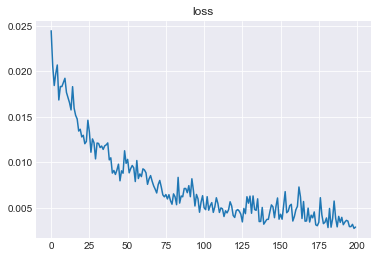

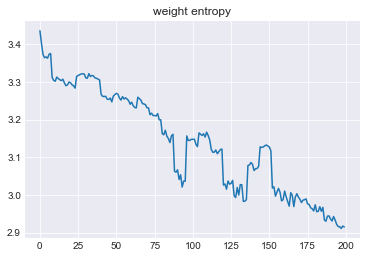

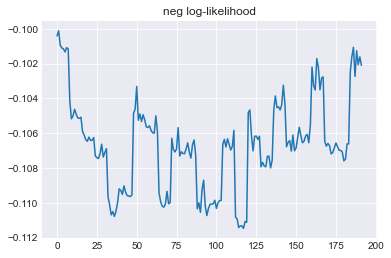

In [24]:
plt.plot(history.history['loss'])
plt.title('loss')
plt.show()

plt.plot(history.history['weight-entropy'])
plt.title('weight entropy')
plt.show()

plt.plot(history.history['prior-loss'])
plt.title('neg log-likelihood')
plt.show()

In [25]:
fit_param_model.get_layer('beta').trainable_variables,param_model.get_layer('beta').trainable_variables

([<tf.Variable 'beta/kernel:0' shape=(1, 1) dtype=float32, numpy=array([[-2.2463827]], dtype=float32)>],
 [<tf.Variable 'beta/kernel:0' shape=(1, 1) dtype=float32, numpy=array([[-2.3025851]], dtype=float32)>])

In [26]:
fit_param_model.summary()

Model: "unbiased_model-model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
R-dist-hypers (TrainableInputLa (None, 2, 4, 4)      32          input_3[0][0]                    
__________________________________________________________________________________________________
R-dist-jitter (Lambda)          (None, 2, 4, 4)      0           R-dist-hypers[0][0]              
__________________________________________________________________________________________________
T-dist-hypers (TrainableInputLa (None, 2, 3, 3)      18          input_3[0][0]                    
_______________________________________________________________________________

In [27]:
fit_param_model.get_layer('rho-dist-start-logit-hypers').trainable_variables,param_model.get_layer('rho-dist-start-logit-hypers').trainable_variables

([<tf.Variable 'value:0' shape=(4,) dtype=float32, numpy=array([-1.1534257 , -0.01820479, -0.11553749, -0.27285507], dtype=float32)>],
 [<tf.Variable 'value:0' shape=(4,) dtype=float32, numpy=array([0., 0., 0., 0.], dtype=float32)>])

In [28]:
hme_fit = np.sum((hme_model.restraint_values * hme_model.traj_weights[:,np.newaxis]), axis=0)
me_fit =  np.sum((me_model.restraint_values * me_model.traj_weights[:,np.newaxis]), axis=0)
print(hme_fit, me_fit)
print(np.mean(hme_fit**2), np.mean(me_fit**2))

[-0.06606974  0.03242216  0.12075309  0.00412351 -0.01614038] [-0.04253438  0.05569238  0.13619171  0.00532583 -0.00500072]
0.004055046 0.0047024735


In [29]:
eh = -np.sum(hme_model.traj_weights * np.log(hme_model.traj_weights))
e =  -np.sum(me_model.traj_weights * np.log(me_model.traj_weights))
print('Maxent', e, 'after tuning', eh)

Maxent 8.491018 after tuning 8.416829


## Direct Regression of Model

In [31]:
T = tmat.value
start = np.zeros((M, C))
start[0,0] = 0.5
infect = maxentep.ContactInfectionLayer(0.1, infections_compartments)
# make "agreement" function
def agreement(traj, rs=restraints):
    s = 0
    for r in rs:
        s += r(traj[0])**2
    return s
rmodel = maxentep.TrainableMetaModel(start, R, T, infect, 250, agreement)

In [32]:
rmodel.compile(optimizer=tf.keras.optimizers.Adam(0.01))
utraj = rmodel.get_traj()
rmodel.fit(100)
rtraj = rmodel.get_traj()

100/100 [==============================] - 8s 80ms/step - loss: 0.0285 - output_2_loss: 0.0285


## Now visualize results

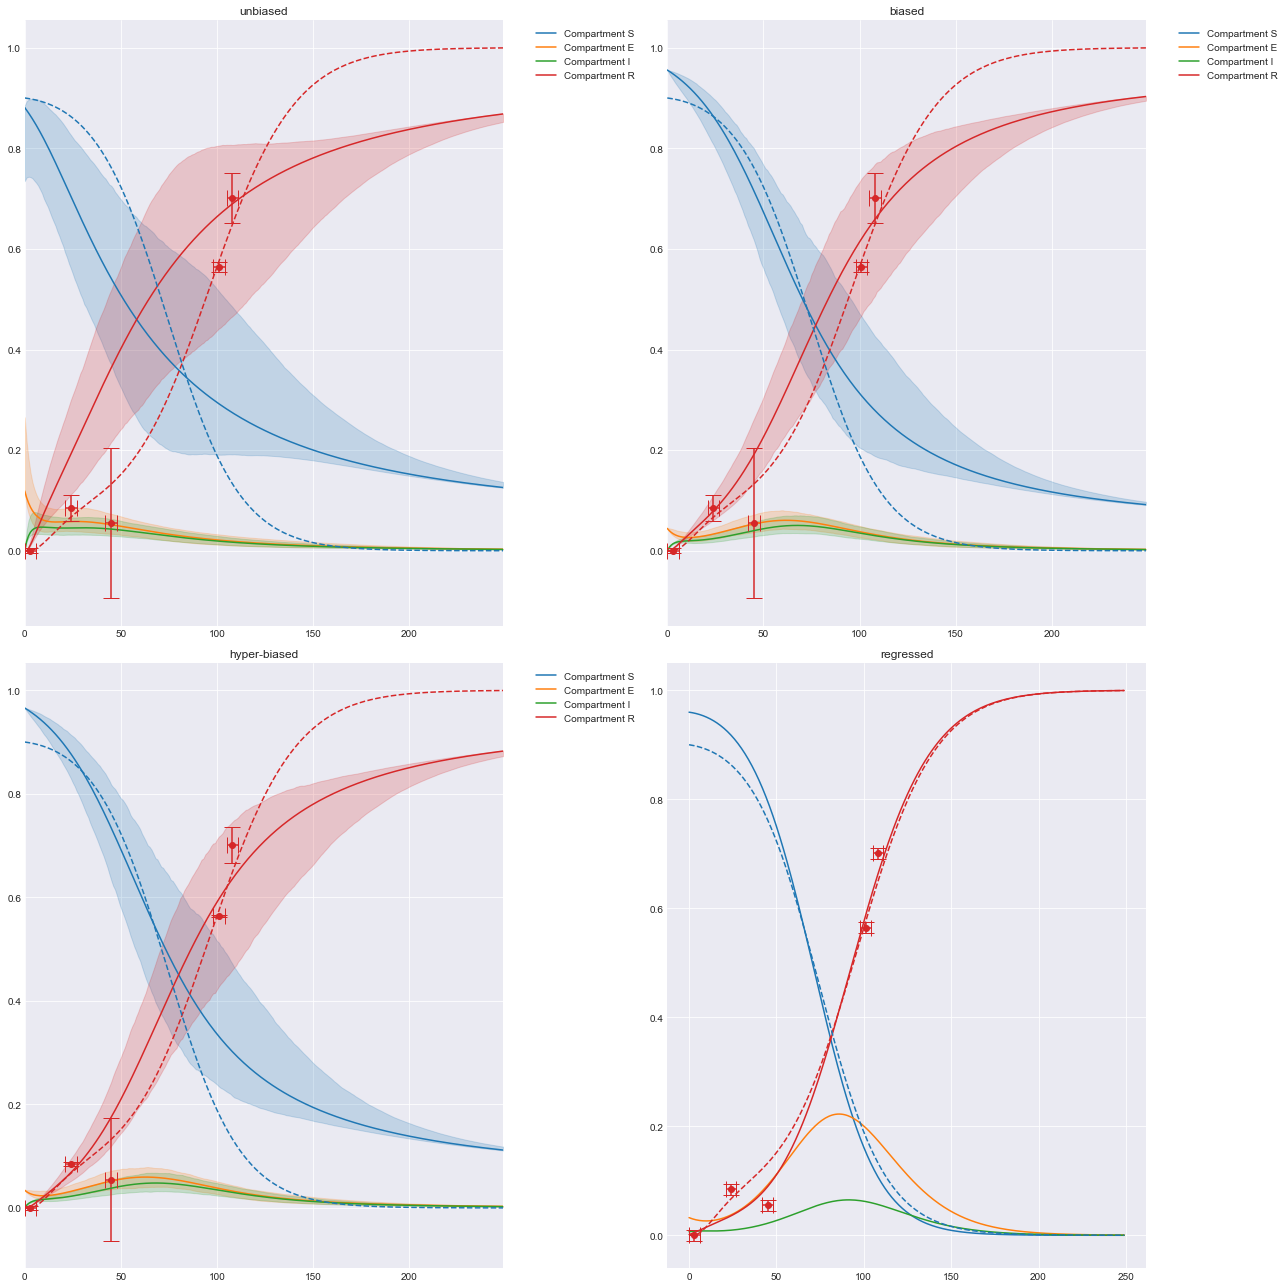

In [33]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(18,18))
axs[0,0].set_title('unbiased')
maxentep.traj_quantile(trajs[:,:,0,:], names=full_compartments, ax=axs[0,0])
axs[0,0].plot(ref_traj[:,0,-1], linestyle='--', color='C3')
axs[0,0].plot(ref_traj[:,0,0], linestyle='--', color='C0')
for i,pf in enumerate(plot_fxns):
    pf(axs[0,0], me_model.lambdas[i], color='C3')

axs[0,1].set_title('biased')
maxentep.traj_quantile(trajs[:,:,0,:], weights=me_model.traj_weights, names=full_compartments, ax=axs[0,1])
axs[0,1].plot(ref_traj[:,0,-1], linestyle='--', color='C3')
axs[0,1].plot(ref_traj[:,0,0], linestyle='--', color='C0')
for i,pf in enumerate(plot_fxns):
    pf(axs[0,1], me_model.lambdas[i], color='C3')
plt.tight_layout()

axs[1,0].set_title('hyper-biased')
maxentep.traj_quantile(hme_model.trajs[:,:,0,:], weights=hme_model.traj_weights, names=full_compartments, ax=axs[1,0])
axs[1,0].plot(ref_traj[:,0,-1], linestyle='--', color='C3')
axs[1,0].plot(ref_traj[:,0,0], linestyle='--', color='C0')
for i,pf in enumerate(plot_fxns):
    pf(axs[1,0], hme_model.lambdas[i], color='C3')
plt.tight_layout()

axs[1,1].set_title('regressed')
axs[1,1].plot(rtraj[0,:,0,:])
axs[1,1].plot(ref_traj[:,0,-1], linestyle='--', color='C3')
axs[1,1].plot(ref_traj[:,0,0], linestyle='--', color='C0')
for i,pf in enumerate(plot_fxns):
    pf(axs[1,1], 1, color='C3')

plt.tight_layout()
plt.savefig('traj_match.png', dpi=300)
plt.show()

## Other Patch

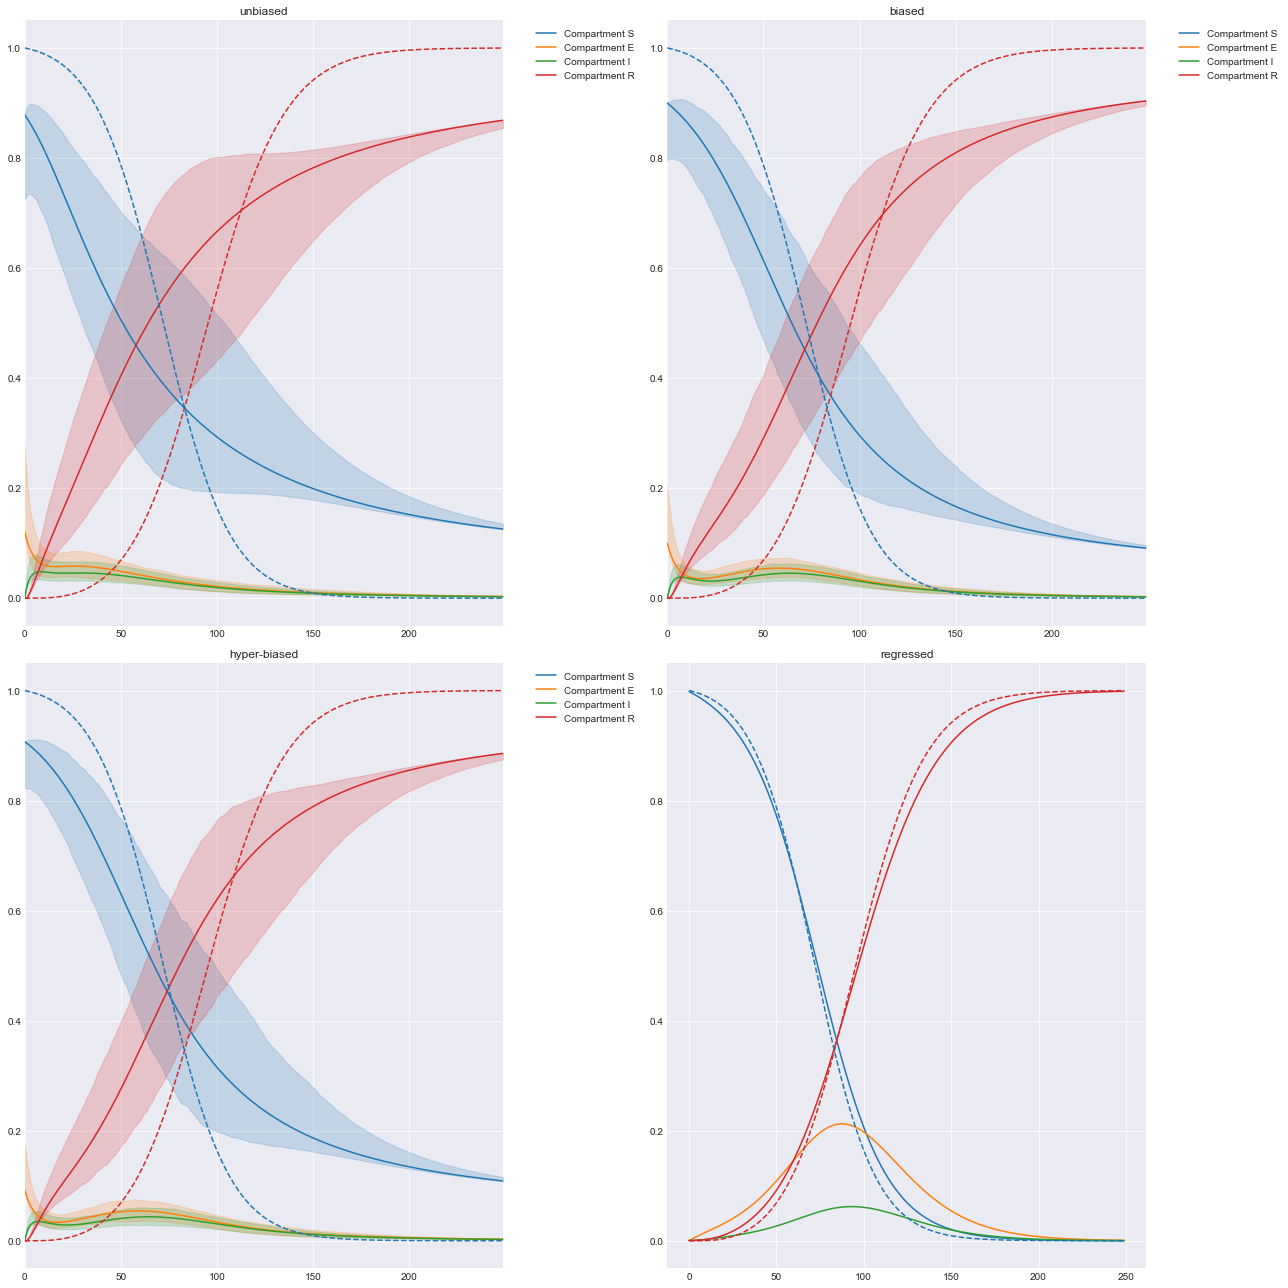

In [34]:
patch = 2
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(18,18))
axs[0,0].set_title('unbiased')
maxentep.traj_quantile(trajs[:,:,patch,:], names=full_compartments, ax=axs[0,0])
axs[0,0].plot(ref_traj[:,patch,-1], linestyle='--', color='C3')
axs[0,0].plot(ref_traj[:,patch,0], linestyle='--', color='C0')

axs[0,1].set_title('biased')
maxentep.traj_quantile(trajs[:,:,patch,:], weights=me_model.traj_weights, names=full_compartments, ax=axs[0,1])
axs[0,1].plot(ref_traj[:,patch,-1], linestyle='--', color='C3')
axs[0,1].plot(ref_traj[:,patch,0], linestyle='--', color='C0')
plt.tight_layout()

axs[1,0].set_title('hyper-biased')
maxentep.traj_quantile(hme_model.trajs[:,:,patch,:], weights=hme_model.traj_weights, names=full_compartments, ax=axs[1,0])
axs[1,0].plot(ref_traj[:,patch,-1], linestyle='--', color='C3')
axs[1,0].plot(ref_traj[:,patch,0], linestyle='--', color='C0')
plt.tight_layout()

axs[1,1].set_title('regressed')
axs[1,1].plot(rtraj[0,:,patch,:])
axs[1,1].plot(ref_traj[:,patch,-1], linestyle='--', color='C3')
axs[1,1].plot(ref_traj[:,patch,0], linestyle='--', color='C0')

plt.tight_layout()
plt.savefig(f'traj_match_patch_{patch}.png', dpi=300)
plt.show()